# Basic Introduction and Summary of Assignment

In this assignment, we will be working with the Titanic dataset. The goal is to load, preprocess, and analyze the data to gain insights into the factors that influenced the survival of passengers. We will perform various data preprocessing steps such as handling missing values, encoding categorical variables, and feature scaling.

## Loading and Preprocessing of the Titanic Dataset

We will start by loading the Titanic dataset and performing necessary preprocessing steps to prepare the data for analysis. This includes:

1. Handling missing values.
2. Encoding categorical variables.
3. Feature scaling.


# Titanic Dataset Description

1. **survival**: Survival (0 = No; 1 = Yes).
2. **class**: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd).
3. **name**: Name.
4. **sex**: Sex.
5. **sibsp**: Number of Siblings/Spouses Aboard.
6. **parch**: Number of Parents/Children Aboard.
7. **ticket**: Ticket Number.
8. **fare**: Passenger Fare.
9. **cabin**: Cabin.
10. **embarked**: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton).
11. **boat**: Lifeboat (if survived).
12. **body**: Body number (if did not survive and the body was recovered).


In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler


# Task 1: Data Loading and Initial Exploration

In [282]:
# Load the dataset
file_path = 'titanic3.xls'
titanic_df = pd.read_excel(file_path)

# Display the first few rows of the dataset
print(titanic_df.head())

# Display the dataset information
print(titanic_df.info())

# Display the summary statistics of the dataset
print(titanic_df.describe())

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

# Task 2: Managing Missing Values

In [283]:
# Count missing values for each column
missing_values_count = titanic_df.isnull().sum()
print("\nMissing Values Count for Each Column:")
print(missing_values_count)

# Filter out rows with missing values
filtered_df = titanic_df.dropna()

# Display the first few rows of the filtered dataset
print("\nFiltered Dataset (No Missing Values):")
print(filtered_df.head())

# Display the dataset information
print("\nFiltered Dataset Info:")
print(filtered_df.info())

# Display the summary statistics of the filtered dataset
print("\nFiltered Dataset Summary Statistics:")
print(filtered_df.describe())


Missing Values Count for Each Column:
pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

Filtered Dataset (No Missing Values):
Empty DataFrame
Columns: [pclass, survived, name, sex, age, sibsp, parch, ticket, fare, cabin, embarked, boat, body, home.dest]
Index: []

Filtered Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     0 non-null      int64  
 1   survived   0 non-null      int64  
 2   name       0 non-null      object 
 3   sex        0 non-null      object 
 4   age        0 non-null      float64
 5   sibsp      0 non-null      int64  
 6   parch      0 non-null      int64  
 7   ticket     0 non-null      object 
 8   fa

In [284]:
# Remove the 'boat' column, as this is dependent on survival status
titanic_df.drop(columns=['boat'], inplace=True)

In [285]:
# Remove the 'body' column, as this is dependent on survival status
titanic_df.drop(columns=['body'], inplace=True)

In [286]:
# Drop the 'name' column
titanic_df.drop(columns=['name'], inplace=True)

In [287]:
# Drop the 'ticket' column as it is not statistically significant
titanic_df.drop(columns=['ticket'], inplace=True)

In [288]:
# Create a contingency table
contingency_table = pd.crosstab(titanic_df['embarked'], titanic_df['survived'])

# Perform the Chi-Square test of independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square Test Statistic:", chi2)
print("P-value:", p)

# Interpret the p-value
alpha = 0.05
if p < alpha:
    print("There is a significant correlation between 'embarked' and 'survived'.")
else:
    print("There is no significant correlation between 'embarked' and 'survived'.")

Chi-Square Test Statistic: 44.24174307145249
P-value: 2.4718809874825634e-10
There is a significant correlation between 'embarked' and 'survived'.


In [289]:
# Fill missing 'embarked' values with the median embarked value
median_embarked = titanic_df['embarked'].mode()[0]
titanic_df['embarked'].fillna(median_embarked, inplace=True)

C:\Users\DAHoe\AppData\Local\Temp\ipykernel_6052\1947013915.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df['embarked'].fillna(median_embarked, inplace=True)


In [290]:
# Create a contingency table
contingency_table_home_dest = pd.crosstab(titanic_df['home.dest'], titanic_df['survived'])

# Perform the Chi-Square test of independence
chi2_home_dest, p_home_dest, dof_home_dest, expected_home_dest = stats.chi2_contingency(contingency_table_home_dest)

print("Chi-Square Test Statistic for 'home.dest' and 'survived':", chi2_home_dest)
print("P-value for 'home.dest' and 'survived':", p_home_dest)

# Interpret the p-value
alpha = 0.05
if p_home_dest < alpha:
    print("There is a significant correlation between 'home.dest' and 'survived'.")
else:
    print("There is no significant correlation between 'home.dest' and 'survived'.")

Chi-Square Test Statistic for 'home.dest' and 'survived': 453.5181628230581
P-value for 'home.dest' and 'survived': 0.001534485424156045
There is a significant correlation between 'home.dest' and 'survived'.


In [291]:
# Calculate the percentage distribution of the existing home.dest values
home_dest_distribution = titanic_df['home.dest'].value_counts(normalize=True)

# Function to fill missing home.dest values based on the distribution
def fill_home_dest(row):
    if pd.isnull(row['home.dest']):
        return np.random.choice(home_dest_distribution.index, p=home_dest_distribution.values)
    else:
        return row['home.dest']

# Apply the function to fill missing home.dest values
titanic_df['home.dest'] = titanic_df.apply(fill_home_dest, axis=1)

In [292]:
# Calculate the median age
median_age = titanic_df['age'].median()

# Substitute the median age for missing age values
titanic_df['age'].fillna(median_age, inplace=True)

C:\Users\DAHoe\AppData\Local\Temp\ipykernel_6052\2160160603.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df['age'].fillna(median_age, inplace=True)


In [293]:
# Calculate the average fare for each class
average_fare_per_class = titanic_df.groupby('pclass')['fare'].mean()

# Fill missing fare values with the average fare of their respective class
titanic_df['fare'] = titanic_df.apply(
    lambda row: average_fare_per_class[row['pclass']] if pd.isnull(row['fare']) else row['fare'],
    axis=1
)

In [294]:
# Calculate the median fare for each cabin
titanic_df['cabin'] = titanic_df['cabin'].str[0]  # Extract the first letter of the cabin
average_fare_per_cabin = titanic_df.groupby('cabin')['fare'].median().to_dict()

# Function to assign cabin based on fare price
def assign_cabin(fare):
    for cabin, median_fare in average_fare_per_cabin.items():
        if fare <= median_fare:
            return cabin
    return 'T'  # Assign 'T' if fare is higher than all median fares

# Fill missing cabin values based on fare price
titanic_df['cabin'] = titanic_df.apply(
    lambda row: assign_cabin(row['fare']) if pd.isnull(row['cabin']) else row['cabin'],
    axis=1
)

In [295]:
# Display the updated dataset information
print(titanic_df.info(verbose=True))

# Show columns with missing values
columns_with_missing_values = titanic_df.columns[titanic_df.isnull().any()]
print("\nColumns with Missing Values:")
print(columns_with_missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   sex        1309 non-null   object 
 3   age        1309 non-null   float64
 4   sibsp      1309 non-null   int64  
 5   parch      1309 non-null   int64  
 6   fare       1309 non-null   float64
 7   cabin      1309 non-null   object 
 8   embarked   1309 non-null   object 
 9   home.dest  1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB
None

Columns with Missing Values:
Index([], dtype='object')


# Task 3: Encoding Categorical Variables

In [296]:
# Perform one-hot encoding for the 'pclass' column
titanic_df = pd.get_dummies(titanic_df, columns=['pclass'], drop_first=False)

In [297]:
# Perform one-hot encoding for the 'sex' column
titanic_df = pd.get_dummies(titanic_df, columns=['sex'], drop_first=False)

In [298]:
# Perform one-hot encoding for the 'embarked' column
titanic_df = pd.get_dummies(titanic_df, columns=['embarked'], drop_first=False)

In [299]:
print(titanic_df.columns)
print(titanic_df.head())

Index(['survived', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'home.dest',
       'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')
   survived      age  sibsp  parch      fare cabin  \
0         1  29.0000      0      0  211.3375     B   
1         1   0.9167      1      2  151.5500     C   
2         0   2.0000      1      2  151.5500     C   
3         0  30.0000      1      2  151.5500     C   
4         0  25.0000      1      2  151.5500     C   

                         home.dest  pclass_1  pclass_2  pclass_3  sex_female  \
0                     St Louis, MO      True     False     False        True   
1  Montreal, PQ / Chesterville, ON      True     False     False       False   
2  Montreal, PQ / Chesterville, ON      True     False     False        True   
3  Montreal, PQ / Chesterville, ON      True     False     False       False   
4  Montreal, PQ / Chesterville, ON      True     False     F

# Task 4: Feature Scaling

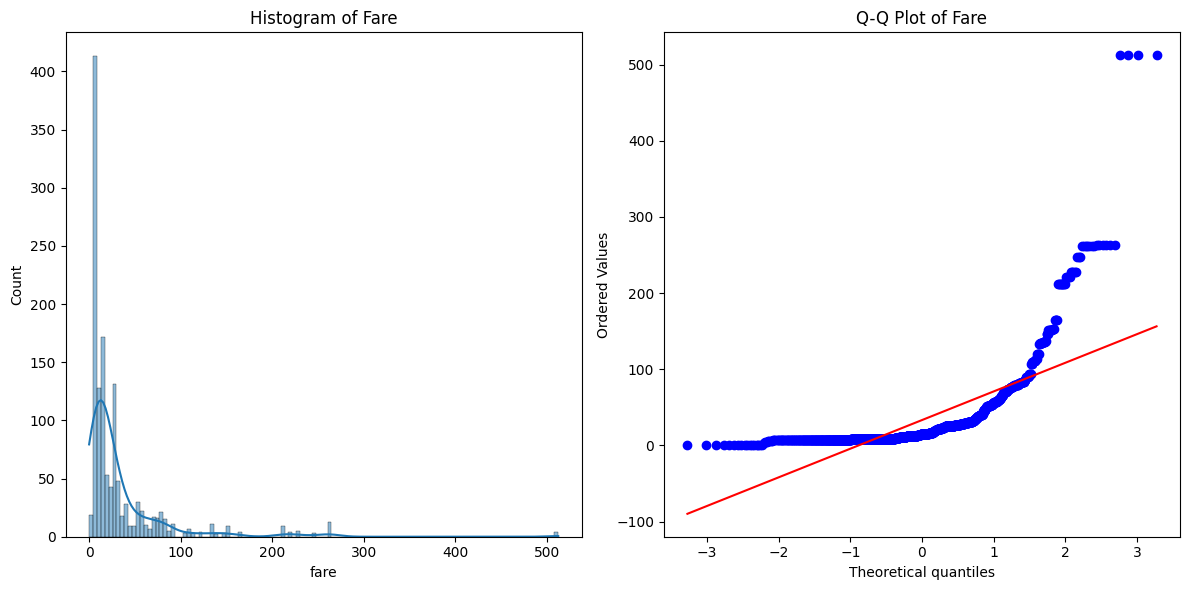

In [300]:
# Plot histogram of the 'fare' column
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(titanic_df['fare'], kde=True)
plt.title('Histogram of Fare')

# Plot Q-Q plot of the 'fare' column
plt.subplot(1, 2, 2)
stats.probplot(titanic_df['fare'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Fare')

plt.tight_layout()
plt.show()

In [301]:

# Initialize the StandardScaler
scaler = StandardScaler()

# Perform standardized scaling for the 'fare' column
titanic_df['fare_scaled'] = scaler.fit_transform(titanic_df[['fare']])

# Display the first few rows of the updated dataset
print(titanic_df[['fare', 'fare_scaled']].head())

       fare  fare_scaled
0  211.3375     3.442579
1  151.5500     2.286641
2  151.5500     2.286641
3  151.5500     2.286641
4  151.5500     2.286641


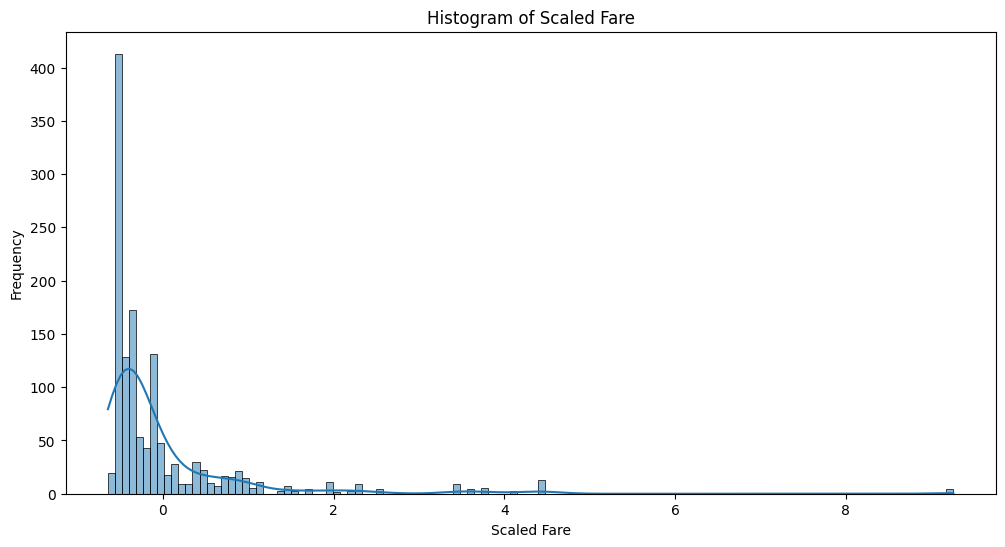

In [302]:
# Plot histogram of the 'fare_scaled' column
plt.figure(figsize=(12, 6))
sns.histplot(titanic_df['fare_scaled'], kde=True)
plt.title('Histogram of Scaled Fare')
plt.xlabel('Scaled Fare')
plt.ylabel('Frequency')
plt.show()

In [303]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
minmax_scaler = MinMaxScaler()

# Perform MinMax scaling for the 'age' column
titanic_df['age_scaled'] = minmax_scaler.fit_transform(titanic_df[['age']])

# Display the first few rows of the updated dataset
print(titanic_df[['age', 'age_scaled']].head())

# Drop the 'age' column as it is now scaled
titanic_df.drop(columns=['age'], inplace=True)

       age  age_scaled
0  29.0000    0.361169
1   0.9167    0.009395
2   2.0000    0.022964
3  30.0000    0.373695
4  25.0000    0.311064


In [304]:
print(titanic_df.columns)
print(titanic_df.head())

Index(['survived', 'sibsp', 'parch', 'fare', 'cabin', 'home.dest', 'pclass_1',
       'pclass_2', 'pclass_3', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'fare_scaled', 'age_scaled'],
      dtype='object')
   survived  sibsp  parch      fare cabin                        home.dest  \
0         1      0      0  211.3375     B                     St Louis, MO   
1         1      1      2  151.5500     C  Montreal, PQ / Chesterville, ON   
2         0      1      2  151.5500     C  Montreal, PQ / Chesterville, ON   
3         0      1      2  151.5500     C  Montreal, PQ / Chesterville, ON   
4         0      1      2  151.5500     C  Montreal, PQ / Chesterville, ON   

   pclass_1  pclass_2  pclass_3  sex_female  sex_male  embarked_C  embarked_Q  \
0      True     False     False        True     False       False       False   
1      True     False     False       False      True       False       False   
2      True     False     False        True     Fal

# Task 5: Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = titanic_df.drop(columns=['survived'])
y = titanic_df['survived']

# Split the dataset into training (50%) and temp (50%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)

# Split the temp set into validation (60% of temp, which is 30% of original) and testing (40% of temp, which is 20% of original) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Display the sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")